In [26]:
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pprint
import os
from shutil import copyfile
from tqdm.notebook import tqdm
import pandas as pd
import h5py

from skimage.io import imread, imsave
from skimage import data, color
from skimage.transform import rescale
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask

In [15]:
data_dir = Path('./data/Density Research Lab 18 samples')
image_dir = Path('./data/imgs')
# image_dir = Path('./data/gans')
# image_dir = Path('./data/psnr-large')
upscale_image_dir = Path('./data/upscale')

coordinate_dir = Path('./data/xy')
os.makedirs(image_dir, exist_ok = True)
os.makedirs(coordinate_dir, exist_ok = True)

proximity_map_path = Path('./data/pmap.h5')
# grayscale_proximity_map_path = Path('./data/grayscale_pmap.h5')
# gans_proximity_map_path = Path('./data/gans_pmap.h5')
# psnrl_proximity_map_path = Path('./data/psnrl_pmap.h5')

patch_img_dir = Path('./data/patch_img')
os.makedirs(patch_img_dir, exist_ok = True)

pmap_patch_img_dir = Path('./data/pmap_patch_img')
os.makedirs(pmap_patch_img_dir, exist_ok = True)
patch_img_pmap = Path('./data/patch_img_pmap.h5')

training_file = Path('./data/train_data.h5')

In [3]:
folder_name = os.listdir(data_dir)
print(folder_name)

['D1 R1 day 9', 'D1 R2 day 9', 'D1 R3 day 9', 'D1 R4 day 9', 'D1 R5 day 9', 'D1 R6 day 9', 'D2 R1 day 9', 'D2 R2 day 9', 'D2 R3 day 9', 'D2 R4 day 9', 'D2 R5 day 9', 'D2 R6 day 9', 'D3 R1 day 9', 'D3 R2 day 9', 'D3 R3 day 9', 'D3 R4 day 9', 'D3 R5 day 9', 'D3 R6 day 9']


In [ ]:
for name in folder_name:
    temp_dir = data_dir / name
    file_list = os.listdir(temp_dir)
    if 'new' in file_list:
        continue
    
    for img_name in file_list:
        if '.tif' in img_name:
            file_name = '{}_{}'.format(name.replace(' ', '_'), img_name)
            copyfile(temp_dir / img_name, image_dir / file_name)

In [16]:
img_list = os.listdir(image_dir)
img_list.sort()

In [21]:
for i in tqdm(range(len(img_list))):
    img = img_as_float(imread(image_dir / img_list[i]))
    img = color.rgb2gray(img)
    img = rescale(img, 2, anti_aliasing=True)
    img = unsharp_mask(img, radius=100, amount=10)
    img = img_as_ubyte(img)
    imsave(upscale_image_dir / img_list[i], img)

In [22]:
img_list = os.listdir(upscale_image_dir)
img_list.sort()
xy_list = os.listdir(coordinate_dir)
xy_list.sort()

In [23]:
def generate_diffusion(max_size):
    g_range = 2
    X,Y=np.meshgrid(np.linspace(-g_range,g_range,max_size),np.linspace(-g_range,g_range,max_size));
    mu,sigma=0,1;
    G=np.exp(-((X-mu)**2+(Y-mu)**2)/2.0*sigma**2)

    return G / (1./ (np.max(G)))

def generate_difusion_map(xy_coord, size, max_distance, factor=1.0):
    additional_width = int(size * 0.2)
    max_size = size + 2*additional_width
    img_arr = np.full((max_size, max_size), 0.0)
    diff_arr = generate_diffusion(max_distance)
    diff_distance = int(np.floor(diff_arr.shape[0]/2.))
    valid_coord = []
    for i in xy_coord:
        if i[0]*factor > size or i[1]*factor > size:
            continue

        y = int(i[0]*factor + additional_width)
        x = int(i[1]*factor + additional_width)
        temp_arr = img_arr[x - diff_distance: x + diff_distance + 1, y - diff_distance: y + diff_distance + 1]
        temp_arr = np.maximum(temp_arr, diff_arr)
        img_arr[x - diff_distance: x + diff_distance + 1, y - diff_distance: y + diff_distance + 1] = temp_arr
        valid_coord.append([int(i[0]*factor), int(i[1]*factor)])
        
    return img_arr[additional_width: additional_width + size, additional_width: additional_width + size], np.array(valid_coord)


In [24]:
with h5py.File(proximity_map_path, 'w') as file:
    for i in tqdm(range(len(img_list))):
        print(upscale_image_dir / img_list[i])
        img = Image.open(upscale_image_dir / img_list[i])
        df = pd.read_csv(coordinate_dir / xy_list[i], index_col=0)
        coords = df[['X', 'Y']].values
        print(img_list[i], xy_list[i], img.size[0])
              
        img_arr, coords = generate_difusion_map(coords, img.size[0], 25, factor=2.0)
        
        file.create_dataset('img/{:03d}'.format(i), data=np.array(img))
        file.create_dataset('pmap/{:03d}'.format(i), data=img_arr)
        file.create_dataset('xy/{:03d}'.format(i), data=coords)

data\upscale\D1_R1_day_9_Image1.tif
D1_R1_day_9_Image1.tif D1_R1_day_9_Image1.csv 400
data\upscale\D1_R1_day_9_Image2.tif
D1_R1_day_9_Image2.tif D1_R1_day_9_Image2.csv 400
data\upscale\D1_R1_day_9_Image3.tif
D1_R1_day_9_Image3.tif D1_R1_day_9_Image3.csv 400
data\upscale\D1_R1_day_9_Image4.tif
D1_R1_day_9_Image4.tif D1_R1_day_9_Image4.csv 400
data\upscale\D1_R1_day_9_Image5.tif
D1_R1_day_9_Image5.tif D1_R1_day_9_Image5.csv 400
data\upscale\D1_R1_day_9_Image6.tif
D1_R1_day_9_Image6.tif D1_R1_day_9_Image6.csv 400
data\upscale\D1_R1_day_9_Image7.tif
D1_R1_day_9_Image7.tif D1_R1_day_9_Image7.csv 400
data\upscale\D1_R1_day_9_Image8.tif
D1_R1_day_9_Image8.tif D1_R1_day_9_Image8.csv 400
data\upscale\D1_R2_day_9_Image1.tif
D1_R2_day_9_Image1.tif D1_R2_day_9_Image1.csv 400
data\upscale\D1_R2_day_9_Image2.tif
D1_R2_day_9_Image2.tif D1_R2_day_9_Image2.csv 400
data\upscale\D1_R2_day_9_Image3.tif
D1_R2_day_9_Image3.tif D1_R2_day_9_Image3.csv 400
data\upscale\D1_R2_day_9_Image4.tif
D1_R2_day_9_Image4

D3_R3_day_9_Image8_dots.tif
1.0 255.0 (400, 400) (400, 400)


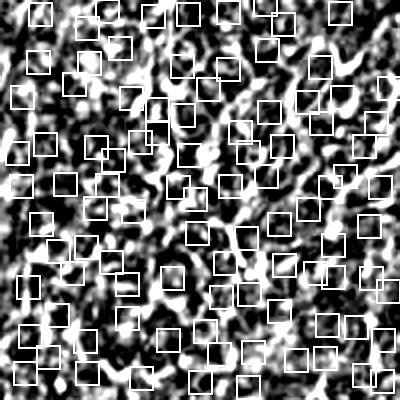

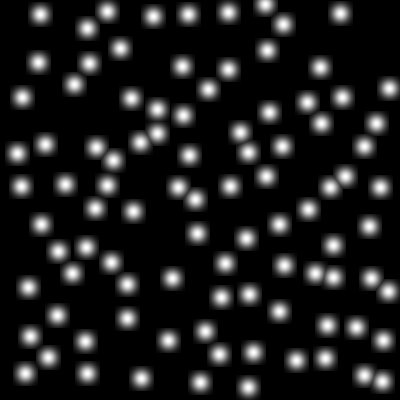

[[ 89  63]
 [ 74  84]
 [ 22  97]
 [ 38  62]
 [ 40  14]
 [107  11]
 [ 87  28]
 [120  48]
 [153  16]
 [131  98]
 [157 109]
 [182  66]
 [188  14]
 [228  12]
 [228  69]
 [208  89]
 [183 115]
 [157 133]
 [107 185]
 [113 160]
 [140 142]
 [ 96 147]
 [ 45 144]
 [ 17 153]
 [ 21 186]
 [ 65 184]
 [ 41 224]
 [ 58 251]
 [ 86 247]
 [ 95 208]
 [133 211]
 [111 262]
 [127 284]
 [127 318]
 [ 85 341]
 [ 57 315]
 [ 72 273]
 [ 28 287]
 [ 30 336]
 [ 48 357]
 [ 25 373]
 [ 87 373]
 [141 378]
 [168 340]
 [172 278]
 [197 233]
 [195 199]
 [178 187]
 [189 155]
 [240 132]
 [230 186]
 [248 152]
 [266 176]
 [282 146]
 [269 112]
 [267  50]
 [265   4]
 [283  24]
 [340  13]
 [320  67]
 [307 102]
 [321 123]
 [342  97]
 [389  88]
 [376 123]
 [364 146]
 [345 176]
 [330 187]
 [308 209]
 [279 224]
 [246 238]
 [284 265]
 [279 311]
 [249 294]
 [221 297]
 [225 263]
 [205 331]
 [219 354]
 [200 382]
 [248 387]
 [253 352]
 [296 360]
 [325 358]
 [356 327]
 [327 325]
 [333 277]
 [333 245]
 [315 273]
 [371 278]
 [369 226]
 [380 187]

In [25]:
sample_num = np.random.randint(low=0, high=len(img_list))
print(img_list[sample_num])
with h5py.File(proximity_map_path, 'r') as file:
    img = Image.fromarray(file.get('img/{:03d}'.format(sample_num))[:])
    pmap = file.get('pmap/{:03d}'.format(sample_num))[:]
    coords = file.get('xy/{:03d}'.format(sample_num))[:]
    
    
    pmap_rescale = pmap * (255./np.max(pmap))
    pmap_img = Image.fromarray(pmap_rescale.astype('uint8'), 'L')
    
    print(np.max(pmap), np.max(pmap_rescale), pmap_img.size, img.size)
    
    draw = ImageDraw.Draw(img)
    size = 12
    for coord in coords:
        draw.rectangle([coord[0] - size,
                        coord[1] - size,
                        coord[0] + size,
                        coord[1] + size], outline=(255), width=2)

    display(img)
    display(pmap_img)
    print(coords)
